# Linear Regression with PyTorch

This tutorial covers implementing linear regression using PyTorch's neural network modules, optimizers, and best practices for machine learning workflows.

## 1. Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device-agnostic setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name()}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using CPU
PyTorch version: 2.8.0+cu126
Device: cpu


## 2. Simple Linear Regression Model

Let's start by defining a simple linear regression model using PyTorch's nn.Module.

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Test the model structure
model = LinearRegression(input_size=1)
print(f"Model: {model}")
print(f"Parameters: {list(model.parameters())}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Model: LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Parameters: [Parameter containing:
tensor([[0.7645]], requires_grad=True), Parameter containing:
tensor([0.8300], requires_grad=True)]
Total parameters: 2


## 3. Generate Synthetic Data

Let's create some synthetic data for our first regression example.

Data shapes: X=torch.Size([1000, 1]), y=torch.Size([1000, 1])
True parameters: weight=2.0, bias=1.0


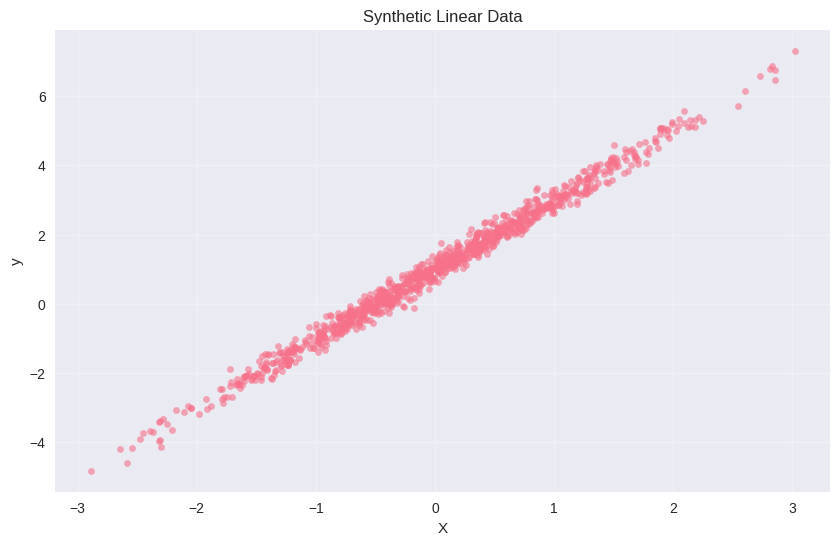

Training set: X_train=torch.Size([800, 1]), y_train=torch.Size([800, 1])
Validation set: X_val=torch.Size([200, 1]), y_val=torch.Size([200, 1])


In [ ]:
def generate_synthetic_data(n_samples=1000, noise_std=0.1):
    """Generate synthetic linear data: y = 2x + 1 + noise"""
    x = torch.randn(n_samples, 1)
    true_weight = 2.0
    true_bias = 1.0
    noise = noise_std * torch.randn(n_samples, 1)
    y = true_weight * x + true_bias + noise
    return x, y, true_weight, true_bias

# Generate data
X_synthetic, y_synthetic, true_w, true_b = generate_synthetic_data(n_samples=1000, noise_std=0.2)

print(f"Data shapes: X={X_synthetic.shape}, y={y_synthetic.shape}")
print(f"True parameters: weight={true_w}, bias={true_b}")

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_synthetic.numpy(), y_synthetic.numpy(), alpha=0.6, s=20)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Linear Data')
plt.grid(True, alpha=0.3)
plt.show()

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_synthetic.numpy(), y_synthetic.numpy(), test_size=0.2, random_state=42
)

# Convert back to tensors and move to device
X_train = torch.FloatTensor(X_train).to(device)
X_val = torch.FloatTensor(X_val).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_val = torch.FloatTensor(y_val).to(device)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set: X_val={X_val.shape}, y_val={y_val.shape}")

## 4. Training Function

Let's create a comprehensive training function with validation.

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val,
                optimizer, criterion, num_epochs=1000, print_every=100):
    """
    Train the model and return training history
    """
    train_losses = []
    val_losses = []

    model.train()

    for epoch in range(num_epochs):
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val)
        model.train()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Train Loss: {train_loss.item():.6f}, '
                  f'Val Loss: {val_loss.item():.6f}')

    return train_losses, val_losses

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

        # Move to CPU for sklearn metrics
        y_test_cpu = y_test.cpu().numpy()
        y_pred_cpu = y_pred.cpu().numpy()

        mse = mean_squared_error(y_test_cpu, y_pred_cpu)
        r2 = r2_score(y_test_cpu, y_pred_cpu)

    return mse, r2, y_pred

## 5. Train the Model

Now let's train our linear regression model on the synthetic data.

In [ ]:
# Initialize model, loss function, and optimizer
model = LinearRegression(input_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"Initial parameters:")
print(f"Weight: {model.linear.weight.item():.4f}")
print(f"Bias: {model.linear.bias.item():.4f}")
print(f"True weight: {true_w}, True bias: {true_b}")

# Train the model
train_losses, val_losses = train_model(
    model, X_train, y_train, X_val, y_val,
    optimizer, criterion, num_epochs=1000, print_every=200
)

print(f"\nFinal parameters:")
print(f"Weight: {model.linear.weight.item():.4f}")
print(f"Bias: {model.linear.bias.item():.4f}")
print(f"True weight: {true_w}, True bias: {true_b}")

Initial parameters:
Weight: -0.2120
Bias: -0.7164
True weight: 2.0, True bias: 1.0
Epoch [0/1000], Train Loss: 7.720278, Val Loss: 7.773450
Epoch [200/1000], Train Loss: 0.548407, Val Loss: 0.527872
Epoch [400/1000], Train Loss: 0.052346, Val Loss: 0.044162
Epoch [600/1000], Train Loss: 0.042835, Val Loss: 0.039619
Epoch [800/1000], Train Loss: 0.042787, Val Loss: 0.039980

Final parameters:
Weight: 2.0074
Bias: 0.9904
True weight: 2.0, True bias: 1.0


## 6. Visualize Training Progress

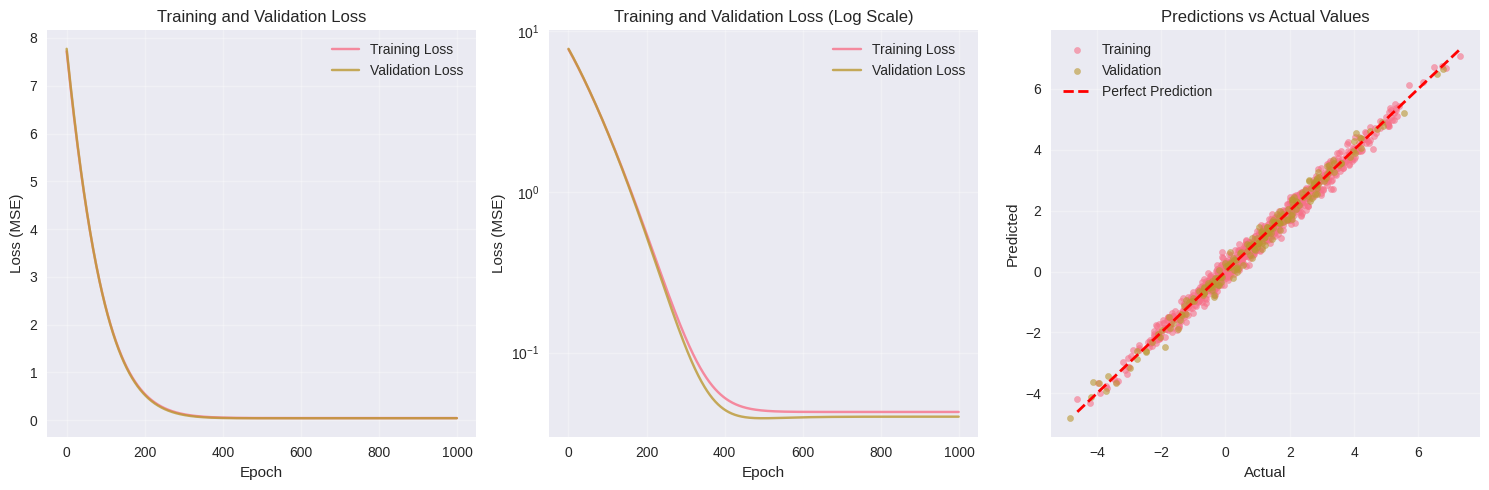

In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Log scale
plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions vs actual
plt.subplot(1, 3, 3)
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_val = model(X_val)

# Move to CPU for plotting
y_train_cpu = y_train.cpu().numpy()
y_val_cpu = y_val.cpu().numpy()
y_pred_train_cpu = y_pred_train.cpu().numpy()
y_pred_val_cpu = y_pred_val.cpu().numpy()

plt.scatter(y_train_cpu, y_pred_train_cpu, alpha=0.6, label='Training', s=20)
plt.scatter(y_val_cpu, y_pred_val_cpu, alpha=0.6, label='Validation', s=20)
plt.plot([y_train_cpu.min(), y_train_cpu.max()], [y_train_cpu.min(), y_train_cpu.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Model Performance:
Training   - MSE: 0.042787, R²: 0.988699
Validation - MSE: 0.039993, R²: 0.990200


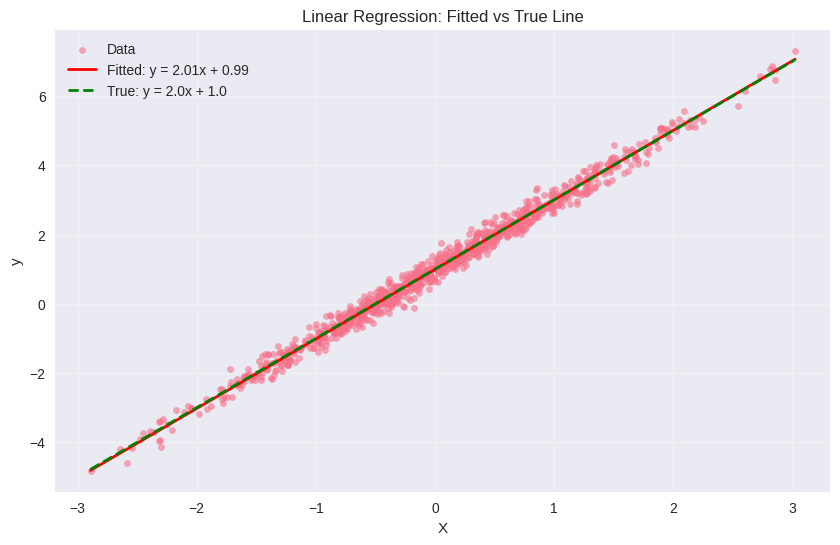

In [ ]:
# Evaluate on both training and validation sets
train_mse, train_r2, _ = evaluate_model(model, X_train, y_train)
val_mse, val_r2, _ = evaluate_model(model, X_val, y_val)

print("Model Performance:")
print(f"Training   - MSE: {train_mse:.6f}, R²: {train_r2:.6f}")
print(f"Validation - MSE: {val_mse:.6f}, R²: {val_r2:.6f}")

# Visualize the fitted line
plt.figure(figsize=(10, 6))

# Plot data points
X_all_cpu = torch.cat([X_train, X_val], dim=0).cpu().numpy()
y_all_cpu = torch.cat([y_train, y_val], dim=0).cpu().numpy()

plt.scatter(X_all_cpu, y_all_cpu, alpha=0.6, s=20, label='Data')

# Plot fitted line
x_line = torch.linspace(X_all_cpu.min(), X_all_cpu.max(), 100).reshape(-1, 1).to(device)
model.eval()
with torch.no_grad():
    y_line = model(x_line)

x_line_cpu = x_line.cpu().numpy()
y_line_cpu = y_line.cpu().numpy()

plt.plot(x_line_cpu, y_line_cpu, 'r-', linewidth=2,
         label=f'Fitted: y = {model.linear.weight.item():.2f}x + {model.linear.bias.item():.2f}')
plt.plot(x_line_cpu, true_w * x_line_cpu + true_b, 'g--', linewidth=2,
         label=f'True: y = {true_w}x + {true_b}')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression: Fitted vs True Line')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Real-World Dataset: California Housing

Let's apply our linear regression to a real-world dataset.

In [ ]:
# Load California Housing dataset
california_housing = fetch_california_housing()
X_housing = california_housing.data
y_housing = california_housing.target
feature_names = california_housing.feature_names

print(f"Dataset shape: X={X_housing.shape}, y={y_housing.shape}")
print(f"Features: {feature_names}")
print(f"Target: Median house value (in hundreds of thousands of dollars)")

# Create DataFrame for exploration
df_housing = pd.DataFrame(X_housing, columns=feature_names)
df_housing['target'] = y_housing

print("\nDataset Info:")
print(df_housing.describe())

Dataset shape: X=(20640, 8), y=(20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in hundreds of thousands of dollars)

Dataset Info:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        targ

In [ ]:
# Preprocess the data
X_train_housing, X_test_housing, y_train_housing, y_test_housing = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_housing_scaled = scaler.fit_transform(X_train_housing)
X_test_housing_scaled = scaler.transform(X_test_housing)

# Convert to tensors and move to device
X_train_housing_tensor = torch.FloatTensor(X_train_housing_scaled).to(device)
X_test_housing_tensor = torch.FloatTensor(X_test_housing_scaled).to(device)
y_train_housing_tensor = torch.FloatTensor(y_train_housing).reshape(-1, 1).to(device)
y_test_housing_tensor = torch.FloatTensor(y_test_housing).reshape(-1, 1).to(device)

print(f"Training shapes: X={X_train_housing_tensor.shape}, y={y_train_housing_tensor.shape}")
print(f"Test shapes: X={X_test_housing_tensor.shape}, y={y_test_housing_tensor.shape}")

Training shapes: X=torch.Size([16512, 8]), y=torch.Size([16512, 1])
Test shapes: X=torch.Size([4128, 8]), y=torch.Size([4128, 1])


In [ ]:
# Create and train model for housing data
class MultiFeatureRegression(nn.Module):
    def __init__(self, input_size):
        super(MultiFeatureRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize model
n_features = X_train_housing_tensor.shape[1]
housing_model = MultiFeatureRegression(input_size=n_features).to(device)
housing_criterion = nn.MSELoss()
housing_optimizer = optim.Adam(housing_model.parameters(), lr=0.01)

print(f"Model for {n_features} features:")
print(f"Total parameters: {sum(p.numel() for p in housing_model.parameters())}")

# Split training data into train/validation
val_size = int(0.2 * len(X_train_housing_tensor))
train_size = len(X_train_housing_tensor) - val_size

X_train_h = X_train_housing_tensor[:train_size]
X_val_h = X_train_housing_tensor[train_size:]
y_train_h = y_train_housing_tensor[:train_size]
y_val_h = y_train_housing_tensor[train_size:]

# Train the model
print("\nTraining on California Housing dataset...")
housing_train_losses, housing_val_losses = train_model(
    housing_model, X_train_h, y_train_h, X_val_h, y_val_h,
    housing_optimizer, housing_criterion, num_epochs=2000, print_every=400
)

Model for 8 features:
Total parameters: 9

Training on California Housing dataset...
Epoch [0/2000], Train Loss: 5.607719, Val Loss: 5.540900
Epoch [400/2000], Train Loss: 0.513509, Val Loss: 0.547214
Epoch [800/2000], Train Loss: 0.511195, Val Loss: 0.545524
Epoch [1200/2000], Train Loss: 0.511195, Val Loss: 0.545526
Epoch [1600/2000], Train Loss: 0.511195, Val Loss: 0.545526


Housing Model Performance:
Training   - MSE: 0.5112, R²: 0.6156
Validation - MSE: 0.5455, R²: 0.6002
Test       - MSE: 0.5592, R²: 0.5733


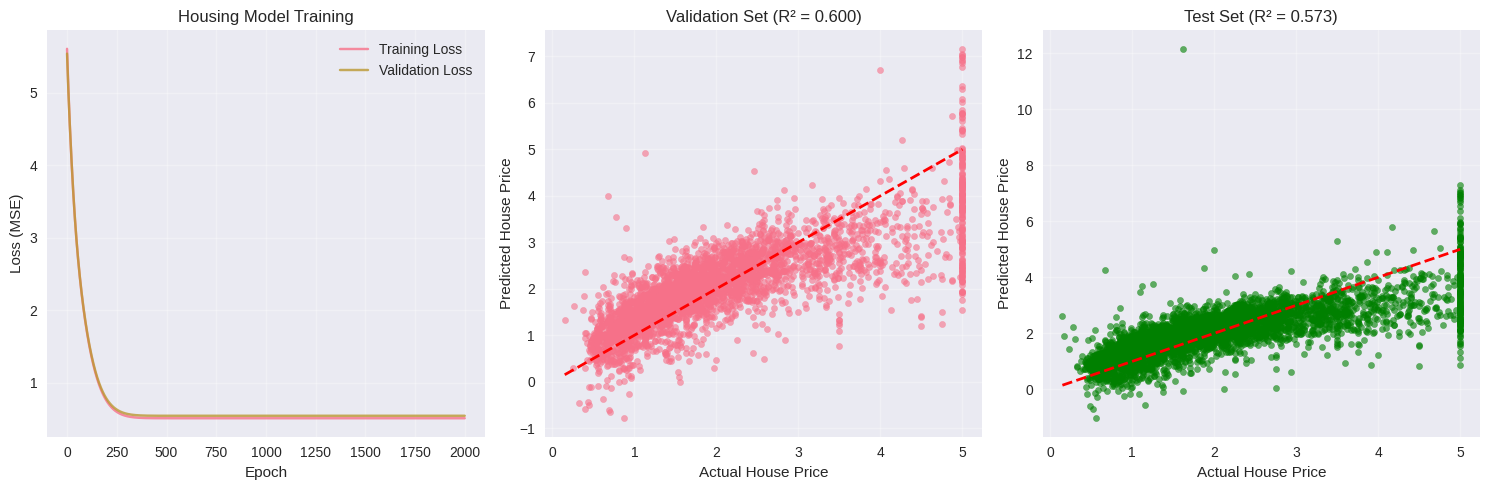

In [ ]:
# Evaluate housing model
train_mse_h, train_r2_h, _ = evaluate_model(housing_model, X_train_h, y_train_h)
val_mse_h, val_r2_h, _ = evaluate_model(housing_model, X_val_h, y_val_h)
test_mse_h, test_r2_h, test_pred_h = evaluate_model(housing_model, X_test_housing_tensor, y_test_housing_tensor)

print("Housing Model Performance:")
print(f"Training   - MSE: {train_mse_h:.4f}, R²: {train_r2_h:.4f}")
print(f"Validation - MSE: {val_mse_h:.4f}, R²: {val_r2_h:.4f}")
print(f"Test       - MSE: {test_mse_h:.4f}, R²: {test_r2_h:.4f}")

# Visualize results
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
plt.plot(housing_train_losses, label='Training Loss', alpha=0.8)
plt.plot(housing_val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Housing Model Training')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions vs actual (validation)
plt.subplot(1, 3, 2)
housing_model.eval()
with torch.no_grad():
    y_pred_val_h = housing_model(X_val_h)

y_val_h_cpu = y_val_h.cpu().numpy()
y_pred_val_h_cpu = y_pred_val_h.cpu().numpy()

plt.scatter(y_val_h_cpu, y_pred_val_h_cpu, alpha=0.6, s=20)
plt.plot([y_val_h_cpu.min(), y_val_h_cpu.max()], [y_val_h_cpu.min(), y_val_h_cpu.max()],
         'r--', linewidth=2)
plt.xlabel('Actual House Price')
plt.ylabel('Predicted House Price')
plt.title(f'Validation Set (R² = {val_r2_h:.3f})')
plt.grid(True, alpha=0.3)

# Predictions vs actual (test)
plt.subplot(1, 3, 3)
y_test_h_cpu = y_test_housing_tensor.cpu().numpy()
test_pred_h_cpu = test_pred_h.cpu().numpy()

plt.scatter(y_test_h_cpu, test_pred_h_cpu, alpha=0.6, s=20, color='green')
plt.plot([y_test_h_cpu.min(), y_test_h_cpu.max()], [y_test_h_cpu.min(), y_test_h_cpu.max()],
         'r--', linewidth=2)
plt.xlabel('Actual House Price')
plt.ylabel('Predicted House Price')
plt.title(f'Test Set (R² = {test_r2_h:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

Feature Importance (Linear Regression Weights):
      Feature    Weight  Abs_Weight
6    Latitude -0.901719    0.901719
7   Longitude -0.872325    0.872325
0      MedInc  0.862921    0.862921
3   AveBedrms  0.358034    0.358034
2    AveRooms -0.308981    0.308981
1    HouseAge  0.121142    0.121142
5    AveOccup -0.044932    0.044932
4  Population -0.007201    0.007201

Bias term: 2.0712


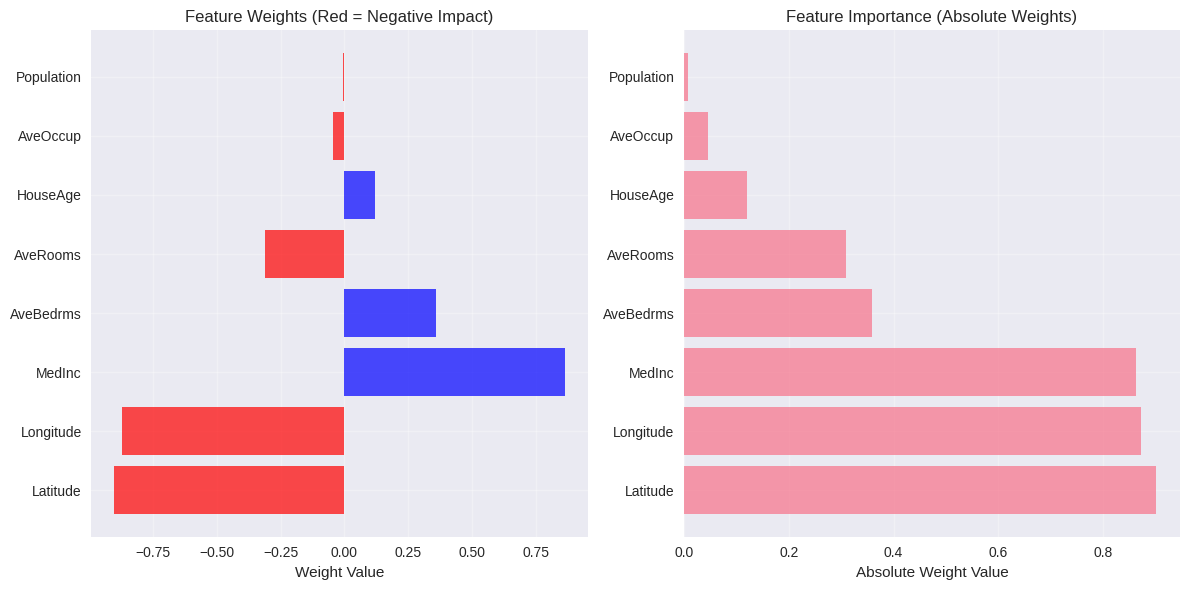

In [ ]:
# Analyze feature importance (weights)
weights = housing_model.linear.weight.data.cpu().numpy().flatten()
bias = housing_model.linear.bias.data.cpu().item()

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
})

feature_importance = feature_importance.sort_values('Abs_Weight', ascending=False)

print("Feature Importance (Linear Regression Weights):")
print(feature_importance)
print(f"\nBias term: {bias:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['red' if w < 0 else 'blue' for w in feature_importance['Weight']]
plt.barh(feature_importance['Feature'], feature_importance['Weight'], color=colors, alpha=0.7)
plt.xlabel('Weight Value')
plt.title('Feature Weights (Red = Negative Impact)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.barh(feature_importance['Feature'], feature_importance['Abs_Weight'], alpha=0.7)
plt.xlabel('Absolute Weight Value')
plt.title('Feature Importance (Absolute Weights)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Comparison of Optimizers

Let's compare different optimizers on the housing dataset.

In [ ]:
def compare_optimizers(X_train, y_train, X_val, y_val, num_epochs=1000):
    """
    Compare different optimizers
    """
    optimizers_config = {
        'SGD': {'class': optim.SGD, 'params': {'lr': 0.01}},
        'Adam': {'class': optim.Adam, 'params': {'lr': 0.01}},
        'RMSprop': {'class': optim.RMSprop, 'params': {'lr': 0.01}},
        'AdamW': {'class': optim.AdamW, 'params': {'lr': 0.01}}
    }

    results = {}

    for opt_name, opt_config in optimizers_config.items():
        print(f"Training with {opt_name}...")

        # Initialize fresh model
        model = MultiFeatureRegression(input_size=X_train.shape[1]).to(device)
        criterion = nn.MSELoss()
        optimizer = opt_config['class'](model.parameters(), **opt_config['params'])

        # Train
        train_losses, val_losses = train_model(
            model, X_train, y_train, X_val, y_val,
            optimizer, criterion, num_epochs=num_epochs, print_every=num_epochs+1
        )

        # Evaluate
        _, _, val_pred = evaluate_model(model, X_val, y_val)
        final_val_loss = val_losses[-1]

        results[opt_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'final_val_loss': final_val_loss,
            'model': model
        }

        print(f"{opt_name} final validation loss: {final_val_loss:.6f}")

    return results

# Compare optimizers
optimizer_results = compare_optimizers(X_train_h, y_train_h, X_val_h, y_val_h, num_epochs=800)

Training with SGD...
Epoch [0/800], Train Loss: 7.228970, Val Loss: 6.986335
SGD final validation loss: 0.556612
Training with Adam...
Epoch [0/800], Train Loss: 5.775350, Val Loss: 5.742962
Adam final validation loss: 0.545521
Training with RMSprop...
Epoch [0/800], Train Loss: 5.360923, Val Loss: 4.688387
RMSprop final validation loss: 0.546057
Training with AdamW...
Epoch [0/800], Train Loss: 7.618488, Val Loss: 7.672439
AdamW final validation loss: 0.545653


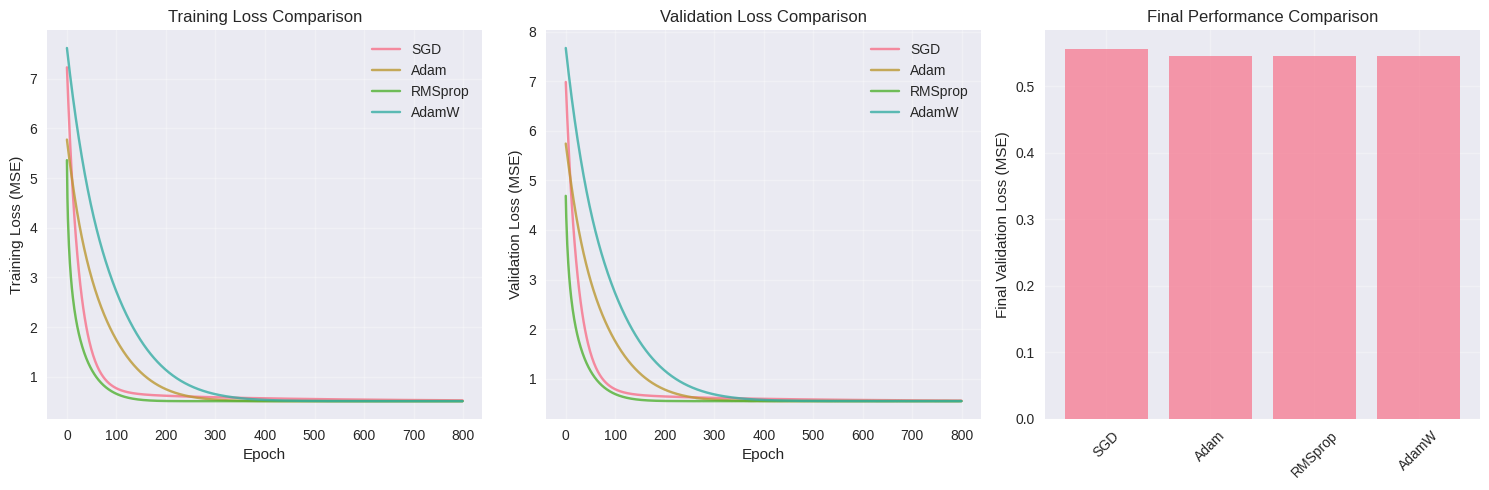


Best optimizer: Adam with validation loss: 0.545521


In [ ]:
# Plot optimizer comparison
plt.figure(figsize=(15, 5))

# Training losses
plt.subplot(1, 3, 1)
for opt_name, results in optimizer_results.items():
    plt.plot(results['train_losses'], label=f'{opt_name}', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation losses
plt.subplot(1, 3, 2)
for opt_name, results in optimizer_results.items():
    plt.plot(results['val_losses'], label=f'{opt_name}', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Final validation losses (bar plot)
plt.subplot(1, 3, 3)
opt_names = list(optimizer_results.keys())
final_losses = [results['final_val_loss'] for results in optimizer_results.values()]
plt.bar(opt_names, final_losses, alpha=0.7)
plt.ylabel('Final Validation Loss (MSE)')
plt.title('Final Performance Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best optimizer
best_optimizer = min(optimizer_results.keys(),
                    key=lambda x: optimizer_results[x]['final_val_loss'])
print(f"\nBest optimizer: {best_optimizer} with validation loss: {optimizer_results[best_optimizer]['final_val_loss']:.6f}")

## 11. Key Takeaways

In this tutorial, we covered:

1. **Model Architecture**: Using `nn.Module` and `nn.Linear` for linear regression
2. **Data Preprocessing**: Standardization for multi-feature datasets
3. **Training Loop**: Proper forward/backward pass, validation, and monitoring
4. **Device-Agnostic Code**: All tensors and models work on CPU, CUDA, or MPS
5. **Model Evaluation**: MSE, R² score, and visualization techniques
6. **Real-World Application**: California Housing dataset
7. **Optimizer Comparison**: SGD vs Adam vs RMSprop vs AdamW
8. **Feature Analysis**: Understanding model weights and feature importance

## Best Practices Learned

- Always split data into train/validation/test sets
- Standardize features for multi-feature regression
- Monitor both training and validation loss
- Use appropriate optimizers (Adam usually works well)
- Evaluate models with multiple metrics (MSE, R²)
- Visualize results to understand model performance
- Write device-agnostic code for portability

## Next Steps

- Proceed to 03_classification for classification problems
- Learn about regularization techniques (L1, L2)
- Explore non-linear regression with neural networks
- Study advanced optimization techniques